# Compute tensorflow neural network transformed estimator

In this notebook we want to figure out how to technically compute the transformed estimator in the case of a transformation defined by a `tensorflow` neural network, in the context of the [Transformer Monte Carlo method](https://gitlab.com/francesco-calcavecchia/deep-twin-sampling-monte-carlo-paper).
The biggest unknown is how to compute the derivative.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


As an example let us consider the integral
$$
\int dx \, \frac{e^{-x^2}}{\sqrt{\pi}} \cos{\frac{x}{2}}
$$

We will sample from the gaussian distribution, and estimate the cosine.

### Standard Monte Carlo integration

In [2]:
rho = tfp.distributions.Normal(loc=0., scale=1.)

In [3]:
def g(x):
    return np.cos(0.5 * x)

In [4]:
Nmc = 100000
x = rho.sample(Nmc)

Let us inspect visually that we sampled from the wanted gaussian distribution:

<AxesSubplot:>

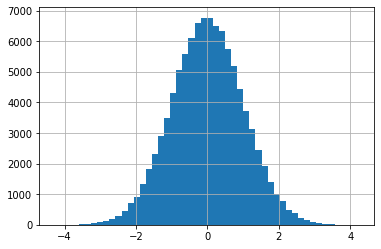

In [5]:
pd.Series(x).hist(bins=50)

We now compute the Monte Carlo integral:

In [6]:
estimates = g(x)

In [7]:
def print_mc_integral(estimates):
    print(f'Integral = { np.mean(estimates)} +- { np.std(estimates)/np.sqrt(Nmc) }')

In [8]:
print_mc_integral(estimates)

Integral = 0.8823508620262146 +- 0.0004946851032210286


### Introduction of the transformation defined by the neural network

Now we introduce the tensorflow neural network. We will consider a simple feed forward neural network with a hidden layer of 3 units, using the sigmoid as activation function. We will use the sigmoid as it belongs to $C^{\infty}$, a desirable property for what we intend to do (even though, strictly speaking, $C^1$ is sufficient).

In [9]:
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, input_shape=(1,), activation=tf.keras.activations.sigmoid, 
                        kernel_initializer='ones', bias_initializer='zeros'),
    tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid, 
                        kernel_initializer='ones', bias_initializer='zeros'),
    tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear, 
                        kernel_initializer=tf.keras.initializers.Constant(17.),
                        bias_initializer=tf.keras.initializers.Constant(-12.5))
])


Notice that we appended a last layer, with a linear activation function: This last layer it only serves the purpose of rescaling the output.

We can visually inspect how will this neural network trasnform the $x$ coordinate:

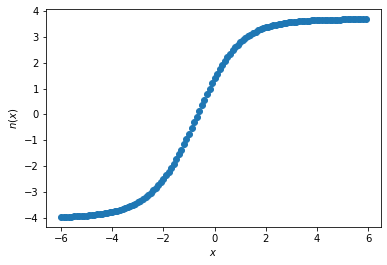

In [10]:
span = np.arange(-6., 6., 0.1)
plt.scatter(x=span, y=(nn.predict([x for x in span])), label=r'$n(x)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$n(x)$')
plt.show()

Notice that the output ranges from $-4$ to $4$, which is sufficient to sample in the whole domain of the gaussian where the probability is meaningfully greater than zero.

### Compute the derivative of the neural network

Now we want to compute the derivative of the neural network. To do so, we will make use of the `GradientTape`, as exaplined [here](https://tensorflow.google.cn/guide/autodiff?hl=en).

We will compute the derivative again on a x range $[-6, 6]$, and we will plot together the value of the neural network, and its first derivative.

In [11]:
x_span = tf.constant([[_] for _ in span])

with tf.GradientTape() as tape:
    tape.watch(x_span)
    y_span = nn(x_span)

In [12]:
dnn_dx_span = tape.gradient(y_span, x_span)

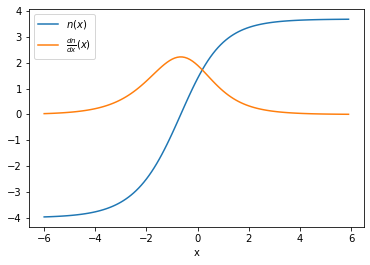

In [13]:
plt.plot(x_span, y_span, label=r'$n(x)$')
plt.plot(x_span, dnn_dx_span, label=r'$\frac{dn}{dx}(x)$')
plt.legend()
plt.xlabel('x')
plt.show()

The plot demonstrates that the derivative has been computed correctly.

### Compute the integral using the transformed estimator

Finally, let us compute the integral using the transformed estimator.

First of all we need to reshape the sampled coordinates to feed the neural network.

In [14]:
x_nn = tf.reshape(x, (len(x), 1))

We then compute the neural network derivative on the sampled coordinates, while computing the transformed coordinates.

In [15]:
with tf.GradientTape() as tape:
    tape.watch(x_nn)
    t = nn(x_nn)
    
dn_dx = tape.gradient(t, x_nn)

Next, we compute the sampling function factors $\frac{\rho(n(x))}{\rho(x)}$:

In [16]:
def compute_rho_factor(x, t):
    return rho.prob(t) / rho.prob(x)

In [17]:
rho_factors = compute_rho_factor(x_nn, t)

Finally the last ingredient: $g(n(x))$:

In [18]:
g_of_t = g(t)

We can now assemble these three ingredients and estimate the integral again:

In [19]:
g_n_estimates = rho_factors * dn_dx * g_of_t

In [20]:
print_mc_integral(g_n_estimates)

Integral = 0.8812863230705261 +- 0.0031945291973647823


As expected the error is larger than the original integration, as we chose a random transformation (neural network). What is important, is that the estimated integral is consistent with what we have found at the beginning of this notebook, i.e. the integral is computed correctly.

### Transformer Monte Carlo

For completeness, we show the Transformer Monte Carlo integral result, by setting the weights equal to $\frac{1}{2}$:

In [26]:
print_mc_integral(0.5 * tf.reshape(g_n_estimates, (Nmc)) + 0.5 * estimates)

Integral = 0.8818185925483704 +- 0.001674936654942212


## Conclusion

We have shown how to technically compute the derivatives needed by the Transformer Monte Carlo method using a `tensorflow` neural network as transformation. At the end, we were able to reconstruct the original integral result within Monte Carlo error bars.